# Crime Analysis
Majid Dareini - Mohammad Hossein Norouzi<br/><br/>
In this notebook we first preprocess the dataset of crimes. <br/>


First we import libraries needed.

In [60]:
import pandas as pd
from sklearn.impute import SimpleImputer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report   
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import nltk

After importing needed libraries, we load the data.

In [2]:
data = pd.read_csv('crime.csv', encoding='iso-8859-1')

/tmp/ipykernel_4748/3746609399.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('crime.csv', encoding='iso-8859-1')


After that it's time for data reduction for `OFFENSE_CODE` and `OFFENSE_DESCRIPTION`. <br/>
because these two columns are so important, if in any row we have lost data of them, it's better to remove the whole column.

In [3]:
imputer_c = SimpleImputer(strategy='constant')
data.drop(index=data['OFFENSE_CODE'].isnull().index, axis=1)
data.drop(index=(data['OFFENSE_DESCRIPTION'] == '').index, axis=1)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location


Then we map hours which their types are integer to strings to be catgorable.

In [33]:
hour_mapping = {
    **{i: "morning" for i in range(0, 12)},
    **{i: "noon" for i in range(12, 19)},
    **{i: "evening" for i in range(19, 25)}
}

data['HOUR'] = data['HOUR'].map(hour_mapping)

After that we handle the missing values. <br/>
We feel the following missing values of each column as described in front of each column's name. <br/> <br/>

`Lat`, `Long` -> With the mean of the datas of its column <br/>
`REPORTING_AREA`, `OCCURRED_ON_DATE`, `YEAR`, `MONTH`, `DAY_OF_WEEK`, `HOUR`, `UCR_PART`, `STREET` -> Replacing with frequent value <br/>
`SHOOTING` -> Replacing with <b>No </b> <br/>

In [42]:
imputer = SimpleImputer(strategy='mean')
data['Lat'] = imputer.fit_transform(data[['Lat']])
data['Long'] = imputer.fit_transform(data[['Long']])

data['REPORTING_AREA'].fillna(data['REPORTING_AREA'].mode().iloc[0])
data['SHOOTING'].fillna('No', inplace=True)
data['OCCURRED_ON_DATE'].fillna(data['OCCURRED_ON_DATE'].mode().iloc[0])
data['YEAR'].fillna(data['YEAR'].mode().iloc[0])
data['MONTH'].fillna(data['MONTH'].mode().iloc[0])
data['DAY_OF_WEEK'].fillna(data['DAY_OF_WEEK'].mode().iloc[0])
if data['HOUR'].isnull().any():
    data['HOUR'].fillna('unknown', inplace=True)
data['UCR_PART'].fillna(data['UCR_PART'].mode().iloc[0])
data['STREET'].fillna(data['STREET'].mode().iloc[0])

0              ARLINGTON ST
1                ALLSTON ST
2                  DEVON ST
3              CAMBRIDGE ST
4               PRESCOTT ST
                ...        
327815          COVENTRY ST
327816             RIVER ST
327817             RIVER ST
327818    NEW WASHINGTON ST
327819        WASHINGTON ST
Name: STREET, Length: 327045, dtype: object

Then we remove the outliers with the help of z-scores on specific numeric columns.

In [43]:
numeric_columns = ['Lat', 'Long']  # Add other numeric columns as needed
z_scores = np.abs((data[numeric_columns] - data[numeric_columns].mean()) / data[numeric_columns].std())
data = data[(z_scores < 3).all(axis=1)]  # Set the z-score threshold as needed

Then we delete the stop words and do stemming.

In [44]:
nltk.download('wordnet')    # just downloading the stopwords
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

data['OFFENSE_DESCRIPTION'] = data['OFFENSE_DESCRIPTION'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package wordnet to /home/majiddrn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Then we start statistic comparison between `OFFENSE_CODE_GROUP` and `DAY_OF_WEEK`. <br/>
Then we can see happening percentage of each crime in every day of the week.

In [45]:
result = data.groupby(['OFFENSE_CODE_GROUP', 'DAY_OF_WEEK']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
print(result)

DAY_OF_WEEK                          Friday     Monday   Saturday     Sunday   
OFFENSE_CODE_GROUP                                                             
Aggravated Assault                14.155374  12.827050  16.704683  16.194821  \
Aircraft                           9.677419   9.677419  29.032258   6.451613   
Arson                             13.043478  16.304348  15.217391  17.391304   
Assembly or Gathering Violations  16.291533   8.788853  34.297964  20.900322   
Auto Theft                        14.532872  14.078720  13.775952  15.030277   
...                                     ...        ...        ...        ...   
Towed                             14.218736  15.093319  16.031016  12.631864   
Vandalism                         14.495317  13.814109  15.752931  15.667780   
Verbal Disputes                   13.529941  14.520486  14.610536  15.270899   
Violations                        15.326633  15.075377  14.398918  11.132586   
Warrant Arrests                   15.516

Now we plot the result of the previous result which was the percentage of each crime in every day of the week.

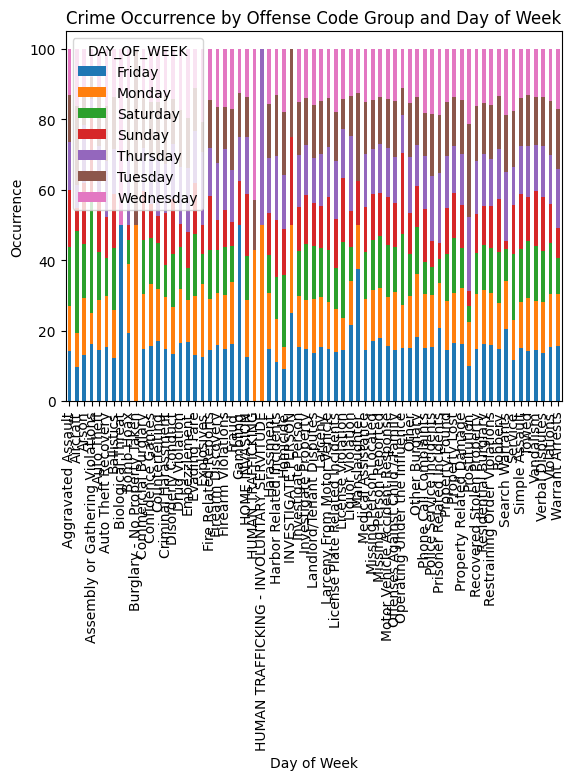

In [46]:
result.plot(kind='bar', stacked=True)

plt.xlabel('Day of Week')
plt.ylabel('Occurrence')
plt.title('Crime Occurrence by Offense Code Group and Day of Week')

plt.show()

## Phase 2

Using all data was expensive in computing and resulted some errors so we used half of dataset.

In [47]:
half_size = len(data) // 4
data_half = data[:half_size]

First we how to encode datas to one-hot encodding.

In [48]:
encoded_data = pd.get_dummies(data_half[['DAY_OF_WEEK','Location','HOUR' ,'OFFENSE_CODE_GROUP']])

Then we apply Apriori algorithm to extract frequent itemsets.

In [49]:
frequent_itemsets = apriori(encoded_data, min_support=0.01, use_colnames=True)

# Filter the frequent itemsets to include only those with three occurrences of ","
# frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: sum(',' in item for item in x) == 3)]
print(frequent_itemsets)

      support                                           itemsets
0    0.151130                               (DAY_OF_WEEK_Friday)
1    0.143193                               (DAY_OF_WEEK_Monday)
2    0.141561                             (DAY_OF_WEEK_Saturday)
3    0.126314                               (DAY_OF_WEEK_Sunday)
4    0.144577                             (DAY_OF_WEEK_Thursday)
..        ...                                                ...
102  0.012467  (DAY_OF_WEEK_Tuesday, OFFENSE_CODE_GROUP_Medic...
103  0.015391  (DAY_OF_WEEK_Tuesday, OFFENSE_CODE_GROUP_Motor...
104  0.012232  (OFFENSE_CODE_GROUP_Larceny, DAY_OF_WEEK_Wedne...
105  0.012558  (OFFENSE_CODE_GROUP_Medical Assistance, DAY_OF...
106  0.014477  (DAY_OF_WEEK_Wednesday, OFFENSE_CODE_GROUP_Mot...

[107 rows x 2 columns]


Now we want to find the top 5 frequent items and plot them.

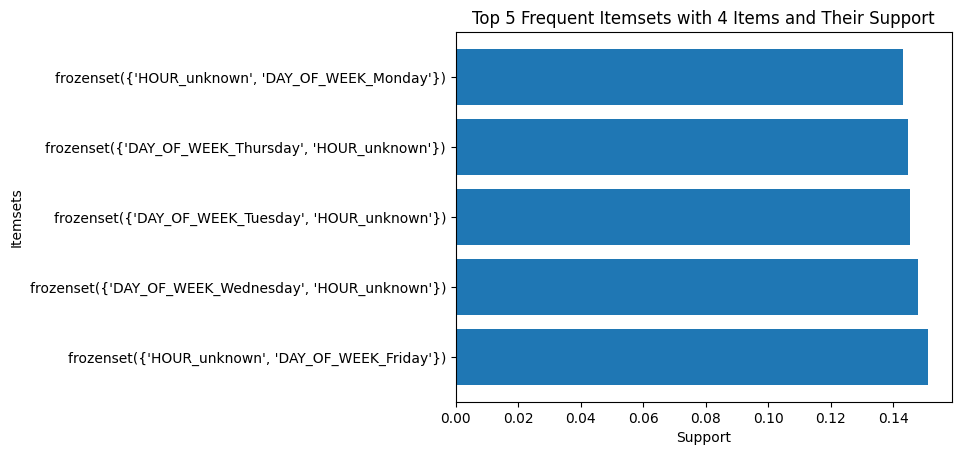

In [50]:
# Filter the frequent itemsets to include only those with exactly 4 items
filtered_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == 2)]

# Sort the filtered itemsets by support in descending order and select the top 5
sorted_itemsets = filtered_itemsets.sort_values(by='support', ascending=False).head(5)

# Plot the top 5 frequent itemsets and their support
plt.barh(range(len(sorted_itemsets)), sorted_itemsets['support'], align='center')
plt.yticks(range(len(sorted_itemsets)), sorted_itemsets['itemsets'].astype(str))
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 5 Frequent Itemsets with 4 Items and Their Support')

plt.show()

Then we generate association rules based on the frequent itemsets.

In [51]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
print(rules)

                                           antecedents   
0                                       (HOUR_unknown)  \
1                                 (DAY_OF_WEEK_Friday)   
2                         (OFFENSE_CODE_GROUP_Larceny)   
3                                 (DAY_OF_WEEK_Friday)   
4              (OFFENSE_CODE_GROUP_Medical Assistance)   
..                                                 ...   
187  (OFFENSE_CODE_GROUP_Motor Vehicle Accident Res...   
188              (HOUR_unknown, DAY_OF_WEEK_Wednesday)   
189  (OFFENSE_CODE_GROUP_Motor Vehicle Accident Res...   
190                            (DAY_OF_WEEK_Wednesday)   
191  (OFFENSE_CODE_GROUP_Motor Vehicle Accident Res...   

                                           consequents  antecedent support   
0                                 (DAY_OF_WEEK_Friday)            1.000000  \
1                                       (HOUR_unknown)            0.151130   
2                                 (DAY_OF_WEEK_Friday)            0.0

## Phase 3

For classification first we select `STREET`, `DAY_OF_WEEK`, `YEAR`, `MONTH`, `HOUR`, `SHOOTING`. and because `STREET`, `DAY_OF_WEEK`(actually to make it catagorical we made it string from integer), `HOUR` are string, we change them to vectors. `OFFENSE_CODE` is integer itself.

In [52]:
selected_columns = ['STREET', 'DAY_OF_WEEK', 'OFFENSE_CODE', 'YEAR', 'MONTH', 'HOUR', 'SHOOTING']
data_selected = data[selected_columns]
label_encoder = LabelEncoder()
data_selected['STREET'] = label_encoder.fit_transform(data_selected['STREET'])
data_selected['DAY_OF_WEEK'] = label_encoder.fit_transform(data_selected['DAY_OF_WEEK'])
data_selected['HOUR'] = label_encoder.fit_transform(data_selected['HOUR'])

/tmp/ipykernel_4748/3142912475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['STREET'] = label_encoder.fit_transform(data_selected['STREET'])
/tmp/ipykernel_4748/3142912475.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['DAY_OF_WEEK'] = label_encoder.fit_transform(data_selected['DAY_OF_WEEK'])
/tmp/ipykernel_4748/3142912475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

Then we represent `X` as all above selected columns except `SHOOTING` as features and represent `y` as `SHOOTING` column which is our lable.<br/>
Then we simply set the train size and test size and train the data with the help of features and lables explained above and train set and their lables.

In [53]:
X = data_selected.drop('SHOOTING', axis=1)
y = data_selected['SHOOTING']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In the end we simply predict the model with the help of test set and its labels.

In [54]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report)

Accuracy: 0.6680645529755397
Classification Report:
               precision    recall  f1-score   support

           N       1.00      0.67      0.80     61071
           Y       0.01      0.74      0.02       212

    accuracy                           0.67     61283
   macro avg       0.50      0.70      0.41     61283
weighted avg       1.00      0.67      0.80     61283



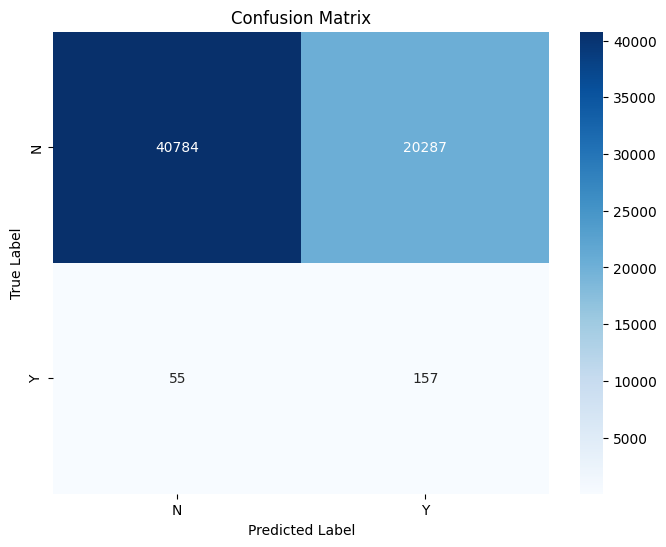

In [55]:
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

First we vecotrize `SHOOTING` which is string.

In [57]:
#first vectorizing `SHOOTING`
data_selected['SHOOTING'] = label_encoder.fit_transform(data_selected['STREET'])

/tmp/ipykernel_4748/207921194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['SHOOTING'] = label_encoder.fit_transform(data_selected['STREET'])


Now we do clustring for the columns selected above.

In [75]:
kmeans = KMeans(n_clusters=10)  
clusters = kmeans.fit_predict(data_selected)

data_selected['Cluster'] = clusters

/home/majiddrn/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_4748/71402670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Cluster'] = clusters


Now we print recall, precision and confusion matrix.

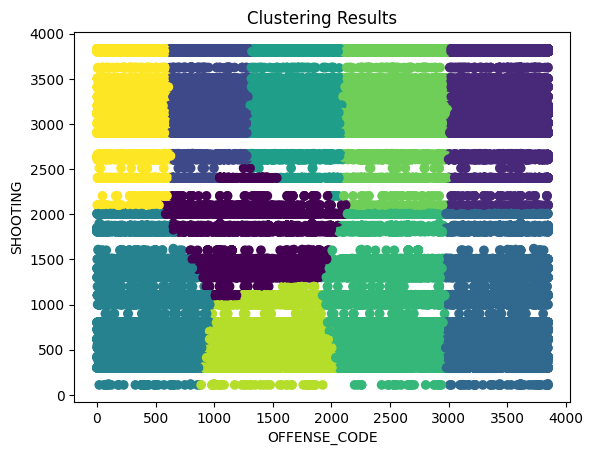

In [76]:
plt.scatter(data_selected['SHOOTING'], data_selected['OFFENSE_CODE'], c=clusters, cmap='viridis')
plt.xlabel('OFFENSE_CODE')
plt.ylabel('SHOOTING')
plt.title('Clustering Results')
plt.show()